In [1]:
import pickle
import sys
import folium
import osmnx as ox
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from collections import defaultdict
from math import ceil
from networkx import MultiDiGraph
from matplotlib import gridspec
from tqdm import tqdm

sys.path.append("..")
from toputils import *

random.seed(233)
tgttop, _, config, projector = read_config(proj=True)
G = pickle.load(open(f"../data_interface/G_{tgttop}.pkl", "rb"))
eid2l = {e["id"]: e["length"] for _, _, e in G.edges(data=True)}
eid2lv = {e["id"]: e["highway"] for _, _, e in G.edges(data=True)}

<Figure size 640x480 with 0 Axes>

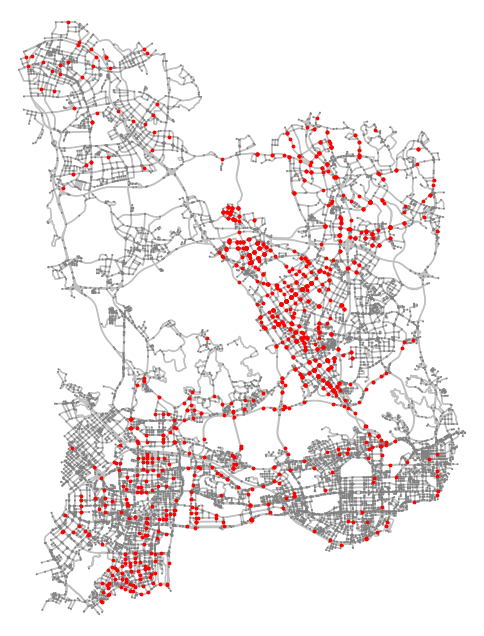

In [8]:
# 画摄像头分布
plt.figure()
G_multi = MultiDiGraph(G)
r2cameras = pickle.load(open(f"../data_interface/r2cameras_{tgttop}.pkl", "rb"))
cameras = list({c["id"]: c for cams in r2cameras.values() for c in cams}.values())
print(len(cameras))
ox.plot_graph(G_multi, node_size=2, bgcolor='white', node_color='gray', edge_color='silver', show=False)
for c in cameras:
    plt.scatter(*c["gps"], color='red', s=3)
plt.savefig(f"figure/cameras_{tgttop}.pdf", bbox_inches="tight")

In [ ]:
trajs = pickle.load(open(f"data/trajs_release_{tgttop}.pkl", "rb"))
print(len(trajs))
print(len({t["vid"] for t in trajs}))

In [8]:
def myplot(args):
    N = len(args)
    plt.figure(figsize=(2*N,6))
    for i, arg in enumerate(args):
        x, xmin, xmax, tick, step, label, title, cdf = arg
        plt.subplot(2, 2, i+1)
        plt.ylabel("CDF" if cdf else "PDF")
        plt.xlabel(label)
        plt.xlim((xmin, xmax))
        plt.gca().xaxis.set_major_locator(MultipleLocator(tick))
        if cdf:
            plt.hist(x=x, bins=np.arange(xmin, xmax + step/2, step), histtype='step', rwidth=0.8, density=True, cumulative=True)
        else:
            plt.hist(x=x, bins=np.arange(xmin, xmax + step/2, step), histtype='bar', rwidth=0.8, density=True, cumulative=False)
        plt.title(title)
        if cdf:
            plt.grid()
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"figure/vis_distribution_{tgttop}.pdf")

In [6]:
# 空间长度分布
lengths = [t["l"] / 1000 for t in trajs]
# 时间长度分布
ts = [t["dr"] / 60 for t in trajs]
# 数量关于道路分布
eid2cnt = defaultdict(int)
for t in trajs:
    nids = [p[0] for p in t["ps"]]
    for u, v in zip(nids, nids[1:]):
        if u != v:
            eid = G.edges[u, v]["id"]
            eid2cnt[eid] += 1
cnts = [x / 1000 for x in eid2cnt.values()]
# 数量关于时间片分布
hs = [int(t["dt"]) / 3600 for t in trajs]

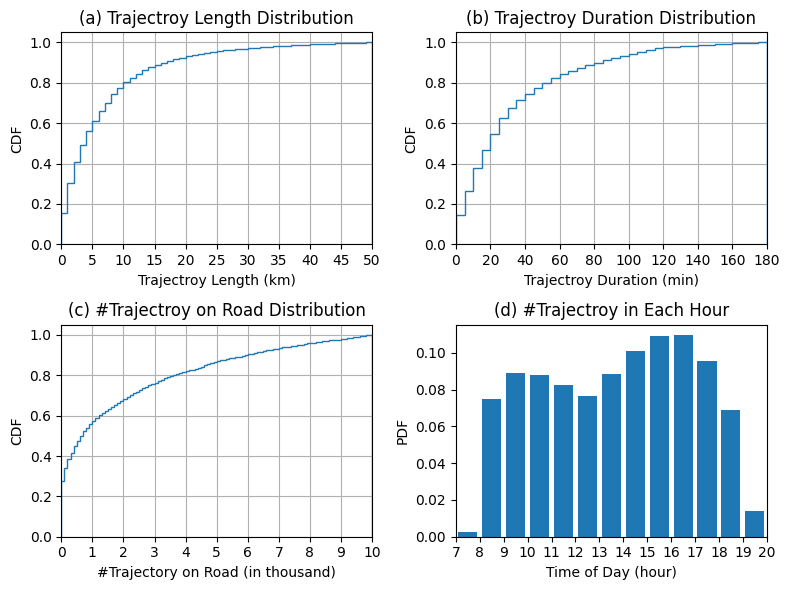

In [9]:
args = []
args.append([lengths, 0, 50, 5, 1, "Trajectroy Length (km)", "(a) Trajectroy Length Distribution", True])
args.append([ts, 0, 180, 20, 5, "Trajectroy Duration (min)", "(b) Trajectroy Duration Distribution", True])
args.append([cnts, 0, 10, 1, 0.1, "#Trajectory on Road (in thousand)", "(c) #Trajectroy on Road Distribution", True])
args.append([hs, 7, 20, 1, 1, "Time of Day (hour)", "(d) #Trajectroy in Each Hour", False])
myplot(args)

In [46]:
# 数量关于空间区域分布（OD）
# 划分grid
G = pickle.load(open(f"../data_interface/G_{tgttop}.pkl", 'rb'))
xys = [(n["xx"], n["yy"]) for _, n in G.nodes(data=True)]
xs, ys = zip(*xys)
min_x, min_y, max_x, max_y = min(xs), min(ys), max(xs), max(ys)
x_step = y_step = 1500
nx, ny = ceil((max_x - min_x) / x_step), ceil((max_y - min_y) / y_step)
step_x, step_y = (max_x - min_x) / nx, (max_y - min_y) / ny
print(nx, ny)

# 统计OD
O1, O2, O3, D1, D2, D3 = [np.zeros((ny, nx)) for _ in range(6)]
ixys2cnt, ixys2cnt1, ixys2cnt2, ixys2cnt3 = [defaultdict(int) for _ in range(4)]
for t in trajs:
    od = []
    for p in [t["ps"][0], t["ps"][-1]]:
        n = G.nodes[p[0]]
        x, y = n["xx"], n["yy"]
        ix, iy = int((x - min_x) / step_x), int((y - min_y) / step_y)
        od.append((ix, iy))
    ixy_o, ixy_d = od
    ixys2cnt[ixy_o, ixy_d] += 1
    h = int(t["ps"][0][1] / 3600)
    if 9 <= h <= 10:
        O, D, ixys2c = O1, D1, ixys2cnt1
    elif 12 <= h <= 13:
        O, D, ixys2c = O2, D2, ixys2cnt2
    elif 16 <= h <= 17:
        O, D, ixys2c = O3, D3, ixys2cnt3
    else:
        continue
    ixys2c[ixy_o, ixy_d] += 1
    ix, iy = ixy_o
    O[ny - 1 - iy, ix] += 1
    ix, iy = ixy_d
    D[ny - 1 - iy, ix] += 1

18 25


In [47]:
ixy2cnt = defaultdict(int)
for ixys, cnt in ixys2cnt.items():
    for ixy in ixys:
        ixy2cnt[ixy] += cnt
print(len(ixy2cnt))
n = sum(ixy2cnt.values())
ixy2cnt = sorted(ixy2cnt.items(), key=lambda x: -x[1])[:40]
print("flow portion in used od:", sum(x[1] for x in ixy2cnt) / n)

ix, iy = ixy2cnt[0][0]
x, y = min_x + ix * step_x, min_y + iy * step_y
print(ix/nx, iy/ny)
print(projector(x, y, inverse=True))

ixy2cnt.sort(key=lambda x: abs(ix - x[0][0]) + abs(iy - x[0][1]))
idx2ixy = {i: ixy_cnt[0] for i, ixy_cnt in enumerate(ixy2cnt)}
OD1, OD2, OD3 = [np.zeros((len(idx2ixy), len(idx2ixy))) for _ in range(3)]
for OD, ixys2c in zip([OD1, OD2, OD3], [ixys2cnt1, ixys2cnt2, ixys2cnt3]):
    for i, ixy1 in idx2ixy.items():
        for j, ixy2 in idx2ixy.items():
            OD[i, j] = ixys2c[ixy1, ixy2]

158
flow portion in used od: 0.7367719991560441
0.6111111111111112 0.4
(114.0166807419777, 22.60820775633943)


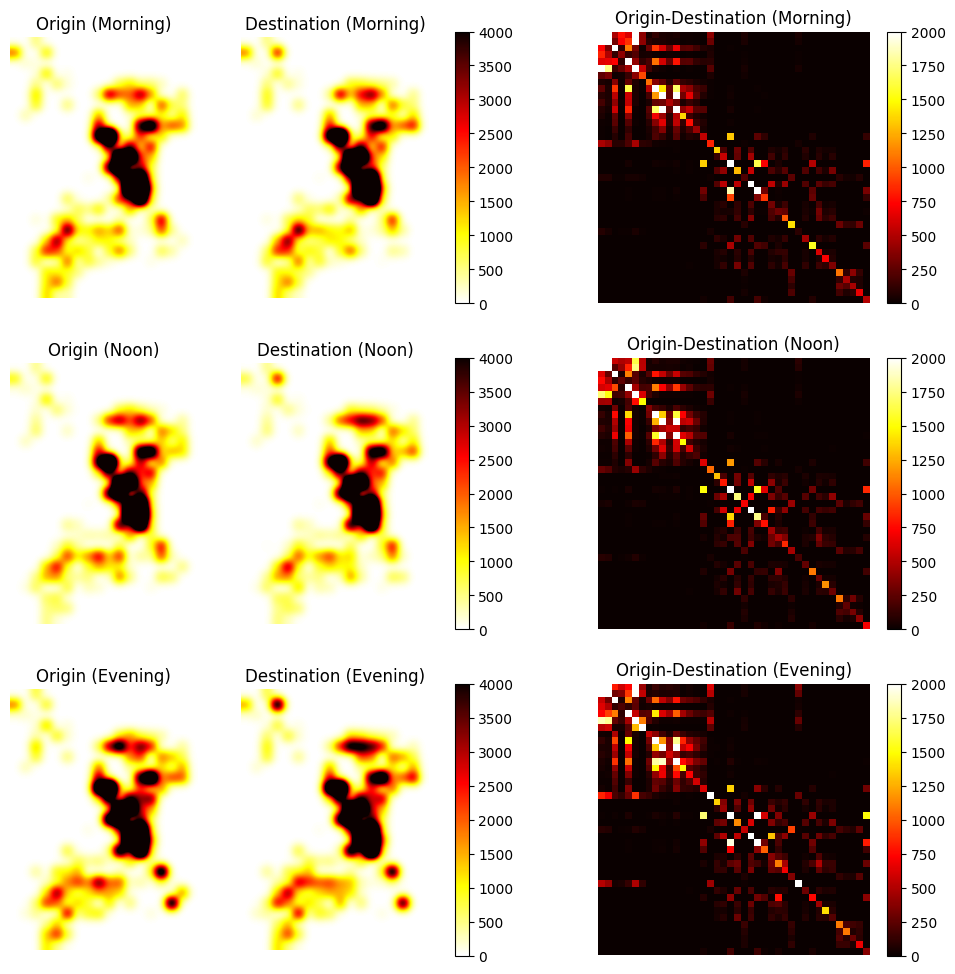

In [52]:
fig = plt.figure(figsize=(12, 12))
cnt = 1
vmax = 4000
idx = 0
for O, D, OD, text in zip([O1, O2, O3], [D1, D2, D3], [OD1, OD2, OD3], ["Morning", "Noon", "Evening"]):
    spec = gridspec.GridSpec(ncols=3, nrows=3, width_ratios=[2, 2, 3])
    ax1 = fig.add_subplot(spec[idx])
    plt.axis("off")
    plt.title(f"Origin ({text})")
    im1 = ax1.imshow(O, extent=(0, nx, 0, ny), cmap=plt.cm.hot_r, interpolation="gaussian", vmin=0, vmax=vmax)
    # plt.colorbar(im1, ax=Wax1)
    idx += 1

    ax2 = fig.add_subplot(spec[idx])
    plt.axis("off")
    plt.title(f"Destination ({text})")
    im2 = ax2.imshow(D, extent=(0, nx, 0, ny), cmap=plt.cm.hot_r, interpolation="gaussian", vmin=0, vmax=vmax)
    plt.colorbar(im2, ax=[ax1, ax2])
    idx += 1

    ax = fig.add_subplot(spec[idx])
    plt.axis("off")
    plt.title(f"Origin-Destination ({text})")
    im = ax.imshow(OD, cmap=plt.cm.hot, vmin=0, vmax=vmax*0.5)
    plt.colorbar(im, ax=ax)
    idx += 1

# plt.tight_layout()
# plt.show()
plt.savefig(f"figure/vis_OD_{tgttop}.pdf", bbox_inches='tight')

In [5]:
# 不同时间片不同等级道路的平均速度
speed_dicts = pickle.load(open( f'../data_interface/road_speed_{tgttop}.pkl', "rb"))
h2lv2s = {h: defaultdict(list) for h in range(24)}
for h, eid2s in enumerate(speed_dicts):
    lv2s = h2lv2s[h]
    for eid, s in eid2s.items():
        lv = eid2lv[eid]
        if isinstance(lv, str):
            lv2s[lv].append(s)
        else:
            for l in lv:
                lv2s[l].append(s)
h2lv2s = {h: {lv: np.mean(s) for lv, s in lv2s.items()} for h, lv2s in h2lv2s.items()}
pprint(h2lv2s[8])

{'living_street': 3.856364038572886,
 'motorway': 17.830723235262877,
 'motorway_link': 11.398436279817997,
 'primary': 8.529209498544958,
 'primary_link': 7.494060455696662,
 'residential': 4.51989533518346,
 'secondary': 7.047701720882062,
 'secondary_link': 6.648231763339441,
 'tertiary': 6.073585404153872,
 'tertiary_link': 5.890214125890936,
 'trunk': 12.35629891933334,
 'trunk_link': 10.015435293486807,
 'unclassified': 4.894524937947527}


In [37]:
# # 计算恢复速度
# eid2h2s = defaultdict(lambda: defaultdict(list))
# for tj in tqdm(trajs):
#     tj = tj["ps"]
#     for (n1, t1), (n2, t2) in zip(tj, tj[1:]):
#         if n1 != n2:
#             eid = G.edges[n1, n2]["id"]
#             v = eid2l[eid] / (t2 - t1 + 1e-12)
#             if 1 < v < 30:
#                 eid2h2s[eid][int((t1 + t2) / 7200)].append(v)
# eid2h2s = {k: dict(v) for k, v in eid2h2s.items()}
# pickle.dump(eid2h2s, open(f"data/eid2h2s_{tgttop}.pkl", "wb"))
eid2h2s = pickle.load(open(f"data/eid2h2s_{tgttop}.pkl", "rb"))

In [44]:
print(len(eid2h2s))
# 过滤1: 在主要的时间片都有数的路
eid2h2s = {k: v for k, v in eid2h2s.items() if all(x in v for x in range(8, 19))}
# 过滤2: 数较多的路
eid2h2s_new = {}
for eid, h2ss in eid2h2s.items():
    if sum(len(ss) for ss in h2ss.values()) > 1000:
        for h in range(8, 19):
            if len(h2ss[h]) < 50:
                break
        else:
            eid2h2s_new[eid] = h2ss
eid2h2s = eid2h2s_new
print(len(eid2h2s))
# 过滤3: 按道路等级的车速先验, 去除outlier值
for eid, h2ss in eid2h2s.items():
    lv = eid2lv[eid]
    for h, ss in h2ss.items():
        lv2s = h2lv2s[h]
        s_ref = lv2s[lv] if isinstance(lv, str) else np.mean([lv2s[l] for l in lv])
        l, u = s_ref * 0.5, s_ref * 1.5
        h2ss[h] = [s for s in ss if l < s < u]
# 过滤2: 数较多的路
eid2h2s_new = {}
for eid, h2ss in eid2h2s.items():
    if sum(len(ss) for ss in h2ss.values()) > 500:
        for h in range(8, 19):
            if len(h2ss[h]) < 25:
                break
        else:
            eid2h2s_new[eid] = h2ss
eid2h2s = eid2h2s_new
print(len(eid2h2s))
# 过滤4: 按绝对中位差去除outlier值
def filter(x, thresh=3):
    """
    基于绝对中位差的异常值过滤
    https://zhuanlan.zhihu.com/p/402171233
    """
    if len(x) < 3:
        return x
    abs = np.abs(x - np.median(x))
    # score = norm.ppf(0.75) * abs / np.median(abs)
    score = 0.67449 * abs / (np.median(abs) + 1e-10)
    return x[score < thresh]
for eid, h2ss in tqdm(eid2h2s.items()):
    for h, ss in h2ss.items():
        h2ss[h] = filter(np.array(ss))
# 过滤2: 数较多的路
eid2h2s_new = {}
for eid, h2ss in eid2h2s.items():
    if sum(len(ss) for ss in h2ss.values()) > 500:
        for h in range(8, 19):
            if len(h2ss[h]) < 25:
                break
        else:
            eid2h2s_new[eid] = h2ss
eid2h2s = eid2h2s_new
print(len(eid2h2s))

11739
4542
4041


100%|██████████| 4041/4041 [08:44<00:00,  7.70it/s] 


4029


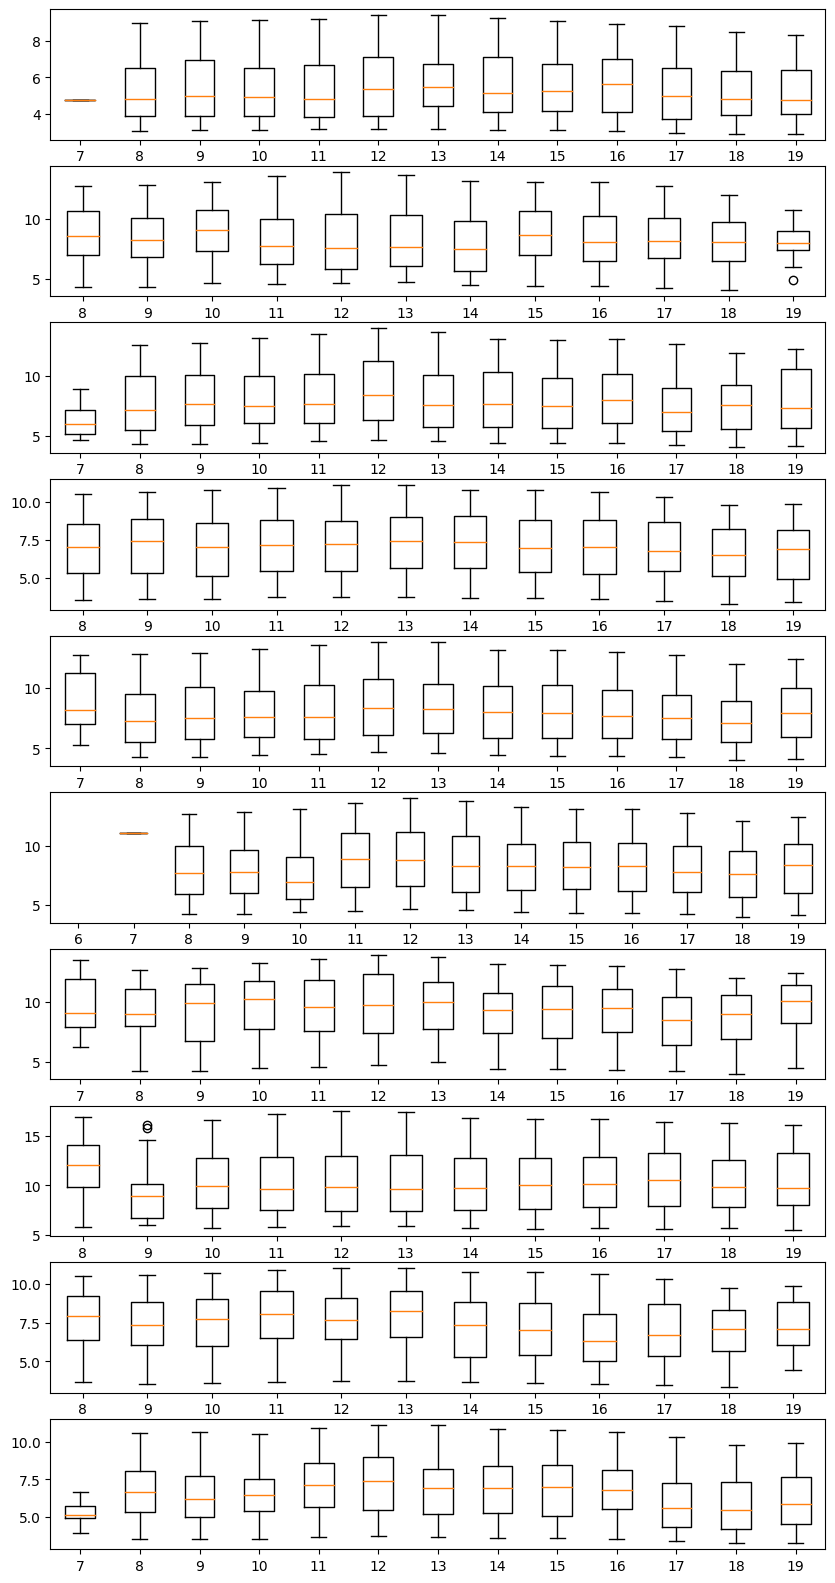

In [31]:
# 随机画一些路在不同小时中的速度的箱型图, 看是否合理
xs = random.sample(list(eid2h2s.values()), 10)
plt.figure(figsize=(10, 20))
for i, h2s in enumerate(xs):
    plt.subplot(10, 1, i+1)
    h2s = sorted(h2s.items(), key=lambda x: x[0])
    plt.boxplot([x[1] for x in h2s], labels=[x[0] for x in h2s], positions=range(len(h2s)))

In [46]:
# 按道路等级与真值对比
lv2ss = defaultdict(list)
for eid, h2s in eid2h2s.items():
    s = np.mean([s for ss in h2s.values() for s in ss])
    lv = eid2lv[eid]
    if isinstance(lv, str):
        lv2ss[lv].append(s)
    else:
        for l in lv:
            lv2ss[l].append(s)
lv2s_rec = {k: np.mean(v) for k, v in lv2ss.items()}

lv2ss = defaultdict(list)
for h in range(8, 19):
    eid2s = speed_dicts[h]
    for eid in eid2h2s:
        s = eid2s[eid]
        lv = eid2lv[eid]
        if isinstance(lv, str):
            lv2ss[lv].append(s)
        else:
            for l in lv:
                lv2ss[l].append(s)
lv2s_gt = {k: np.mean(v) for k, v in lv2ss.items()}
lv2s_gt = sorted(lv2s_gt.items(), key=lambda x: x[1])

# 按时间片与真值对比
h2ss = defaultdict(list)
for eid, h2s in eid2h2s.items():
    for h, ss in h2s.items():
        h2ss[h].append(np.mean(ss))
h2s_rec = {k: np.mean(v) for k, v in h2ss.items()}

h2ss = defaultdict(list)
for h in range(8, 19):
    eid2s = speed_dicts[h]
    for eid in eid2h2s:
        h2ss[h].append(eid2s[eid])
h2s_gt = {k: np.mean(v) for k, v in h2ss.items()}

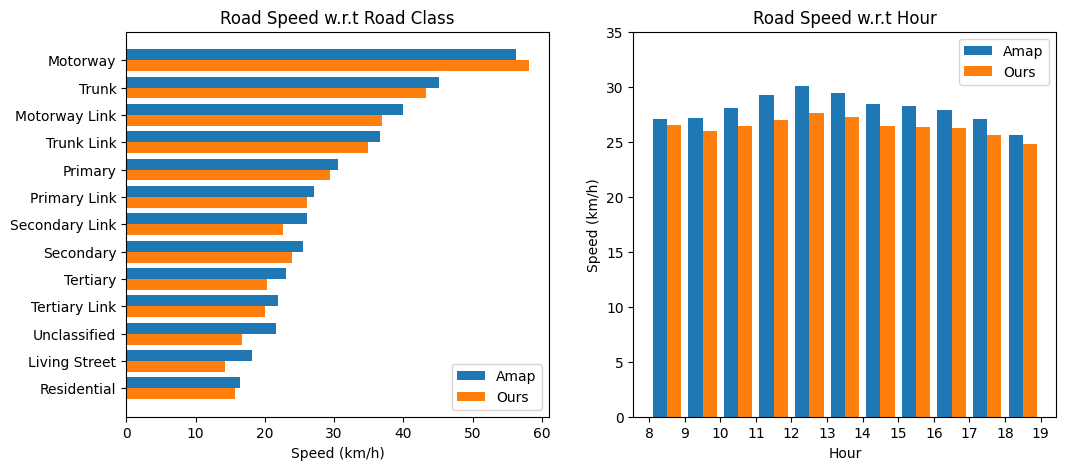

In [54]:
def conv_str(s):
    return " ".join([x.capitalize() for x in s.split("_")])

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
xs = [x * 2 for x in range(len(lv2s_gt))]
plt.barh([x + 0.8 for x in xs], [x[1] * 3.6 for x in lv2s_gt], label="Amap")
plt.barh(xs, [lv2s_rec[x[0]] * 3.6 for x in lv2s_gt], label="Ours")
plt.yticks(ticks=[x + 0.4 for x in xs], labels=[conv_str(x[0]) for x in lv2s_gt])
plt.legend()
plt.xlabel("Speed (km/h)")
plt.title("Road Speed w.r.t Road Class")

plt.subplot(1, 2, 2)
hs = list(range(8, 19))
s_gt = [h2s_gt[h] * 3.6 for h in hs]
s_rec = [h2s_rec[h] * 3.6 for h in hs]
xs = [x * 2 for x in range(len(hs))]
plt.bar(xs, s_gt, label="Amap")
plt.bar([x + 0.8 for x in xs], s_rec, label="Ours")
xs = [x + 0.4 - 1 for x in xs]  # 把柱子放在两个小时中间
xs.append(xs[-1] + 2)
hs.append(hs[-1] + 1)
plt.xticks(ticks=xs, labels=hs)
plt.legend()
plt.xlabel("Hour")
plt.ylabel("Speed (km/h)")
plt.ylim((0, 35))
plt.title("Road Speed w.r.t Hour")

# plt.show()
plt.savefig(f"figure/compare_speed_{tgttop}.pdf", bbox_inches='tight')

In [52]:
# 直接计算所有路,所有时间片下的差异指标 (km/h)
x_rec, x_gt = [], []
for eid, h2s in eid2h2s.items():
    for h in range(8, 19):
        x_rec.append(np.mean(h2s[h]))
        x_gt.append(speed_dicts[h][eid])
x_rec = np.array(x_rec) * 3.6
x_gt = np.array(x_gt) * 3.6
dif = x_rec - x_gt
print("ME:", np.mean(dif))
print("MAE:", np.mean(np.abs(dif)))
print("MAPE:", np.mean(np.abs(dif / x_gt)))
print("RMSE:", np.mean(dif * dif) ** 0.5)

ME: -1.617395967375936
MAE: 7.138183348796109
MAPE: 0.28559671474407017
RMSE: 9.394803813879436
